# Fireworks Galaxy Observation

#### Importing libraries

In [1]:
#GENERAL
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as mtpltcm
from mpl_toolkits.mplot3d import Axes3D
import random
import time

import os
import os.path
from pathlib import Path
import glob
from scipy.io import loadmat
import nibabel as nib
import csv
from astropy.visualization import astropy_mpl_style
from astropy.utils.data import get_pkg_data_filename
from astropy.io import fits
import astropy
from astropy import units as u 
import astropy.wcs as fitswcs
#from specutils import Spectrum1D, SpectralRegion
from astropy.cosmology import WMAP9 as Cosmology

from PIL import Image
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.preprocessing import image
from skimage.feature import hessian_matrix, hessian_matrix_eigvals
from scipy.ndimage.filters import convolve
from skimage import data, io, filters
import skimage.morphology as morph
import skimage.exposure as skie
import skimage
from skimage.morphology import convex_hull_image, erosion
from IPython import display
from scipy.ndimage import gaussian_filter
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.patches as patches

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from keras import regularizers
from sklearn.preprocessing import LabelEncoder
import sklearn

from scipy.io.wavfile import read, write
import librosa
import librosa.display
import IPython
from IPython.display import Audio
import scipy
from scipy import signal
from scipy.fft import fftshift

from warnings import filterwarnings
filterwarnings("ignore",category=DeprecationWarning)
filterwarnings("ignore", category=FutureWarning) 
filterwarnings("ignore", category=UserWarning)
filterwarnings("ignore", category=RuntimeWarning)

#### Load the Images

In [2]:
base = "C:\\Users\\Shibin Paul\\Documents\\ML_projects\\Space Image Data Processing with Python\\Code\\Dataset\\GALAXIES_CENTER\\"


NEAR_INFRARED_PATH = base + "NGC6946\\NEAR_INFRARED\\n4k48nbsq_cal.fits"
HST_OPTICAL_PATH = base + "NGC6946\\OPTICAL\\HST\\idk404050\\idk404050_drc.fits"
XMM_NEWTON_PATH = base + "NGC6946\\XMM_NEWTON_Soft_Xray\\P0200670301EPX0003COLIM8000.FTZ"
XMM_OM_PATH = base + "NGC6946\\XMM_OM_Optical\\P0200670301OMX000LSIMAGB000.FTZ"
ISO_PATH = base + "NGC6946\\ISO\\csp3390040401.fits"

In [3]:
NI_OPEN = fits.open(NEAR_INFRARED_PATH)
HST_OPEN = fits.open(HST_OPTICAL_PATH)
XMM_NEWTON_OPEN = fits.open(XMM_NEWTON_PATH)
XMM_OM_OPEN = fits.open(XMM_OM_PATH)
ISO_OPEN = fits.open(ISO_PATH)

In [4]:
HST_SCI = HST_OPEN[1].data

In [5]:
WIDE_SCALE_HST = HST_SCI[700:4000,700:4000]
ZOOMED_SCALE_HST = HST_SCI[1800:3400,1700:3200]
ZOOMED_X2_SCALE_HST = HST_SCI[2100:3100,2000:3000]
ZOOMED_X3_SCALE_HST = HST_SCI[2450:2850,2300:2700]
NUCLEUS_SCALE_HST = HST_SCI[2640:2850,2330:2650]

In [7]:
SPECTRAL_LIST = ["gray","jet","hot","prism","nipy_spectral","gist_ncar","gist_earth","gist_stern","flag","gnuplot2",'terrain']

#### This notebook goes over the following techniques,
1. An image pre-processing technique called Adaptive Histogram Equalization. This technique improves contrast in images by systematically redistributing luminance, unlike the trial and  error nature of image stacking. 
2. Spectroscopy is vital to visualize and analyze various frequencies available in the FITS image, this can prove useful in astronomical data as the telescopes and instruments used to capture these images often capture in different frequencies.

## Histogram Equalization

**Adaptive histogram equalization (AHE)** is an image pre-processing technique used to improve contrast in images. It computes several histograms, each corresponding to a distinct section of the image, and uses them to redistribute the luminance values of the image. It is therefore suitable for improving the local contrast and enhancing the definitions of edges in each region of an image. However, AHE has a tendency to overamplify noise in relatively homogeneous regions of an image.

A variant of adaptive histogram equalization called **Contrast-Limited Adaptive Histogram Equalization (CLAHE)** prevents this effect by limiting the amplification. CLAHE operates on small regions in the image, called tiles, rather than the entire image. 

The neighboring tiles are then combined using bilinear interpolation to remove the artificial boundaries. This algorithm can be applied to improve the contrast of images. 

We can also apply CLAHE to color images, where usually it is applied on the luminance channel and the results after equalizing only the luminance channel of an HSV image are much better than equalizing all the channels of the BGR image. 

#### To use in CLAHE in OpenCV:
* First, create an object using 
```
clahe_obj = cv2.createCLAHE(clipLimit,tileGridSize)
```

* Then use the apply() method to obtain the equalized result
```
equalized_img = clahe_obj.apply(src, dst)
```

In [34]:
# create a CLAHE object
Clahe_Func = cv2.createCLAHE(clipLimit=5.0,tileGridSize=(3,3))

In [35]:
#Apply the equalization to two images
CLAHE_ZOOMED_X2 = Clahe_Func.apply(ZOOMED_X3_SCALE_HST.astype(np.uint8))
CLAHE_NUCLEUS_CLAHE = Clahe_Func.apply(NUCLEUS_SCALE_HST.astype(np.uint8))

In [ ]:
def plot_filtrd_imgs(main_img,density_ref,spectral_list):
    for x_spec in spectral_list:
    
        figure,axis = plt.subplots(1,2,figsize=(20,20))

        axis[0].imshow(main_img,cmap=x_spec)
        axis[0].set_title("ZOOMED" + " / "+ x_spec)
        axis[0].axis("off")

        DENSITY_FUNC = axis[1].imshow(density_ref,cmap=x_spec)
        axis[1].set_title("NUCLEUS" + " / "+ x_spec)
        axis[1].axis("off")

        figure.colorbar(DENSITY_FUNC,shrink=0.3,label="DENSITY",extend="max")
        plt.tight_layout()
        plt.show()

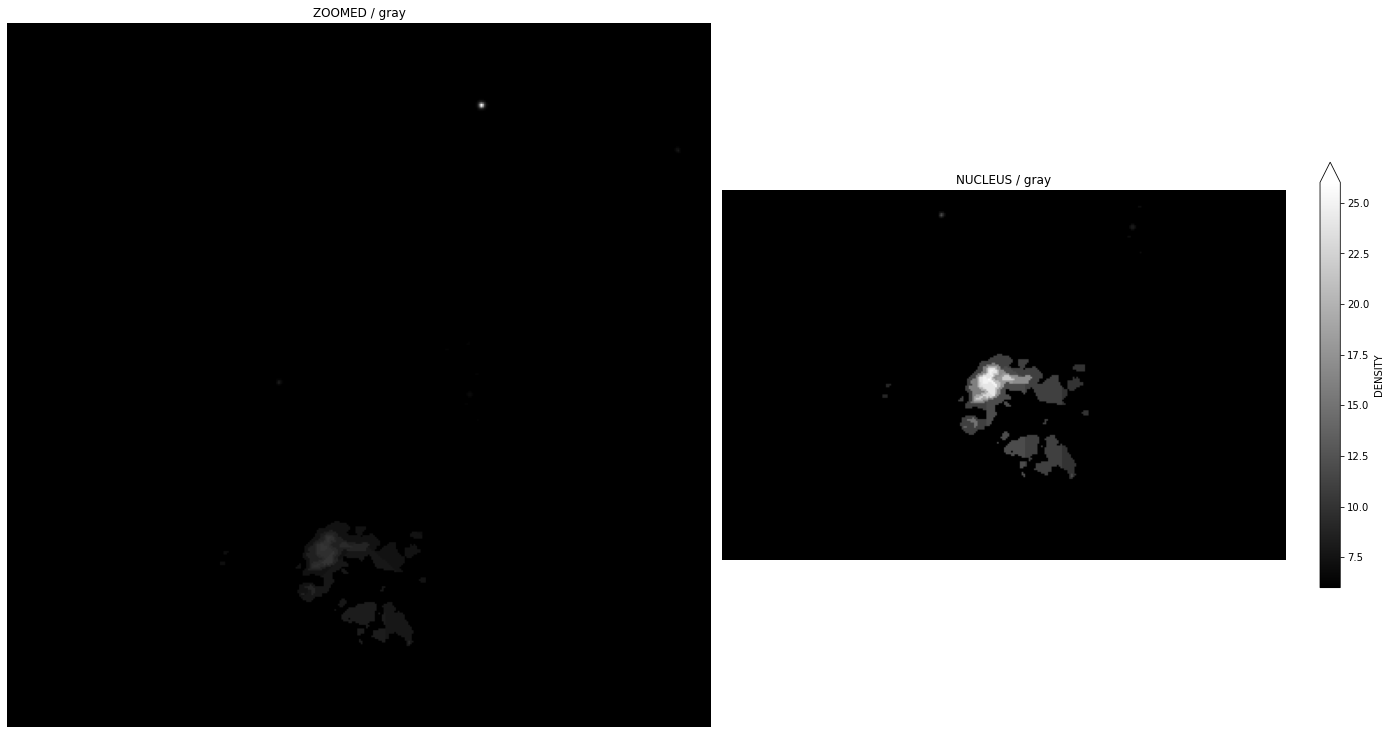

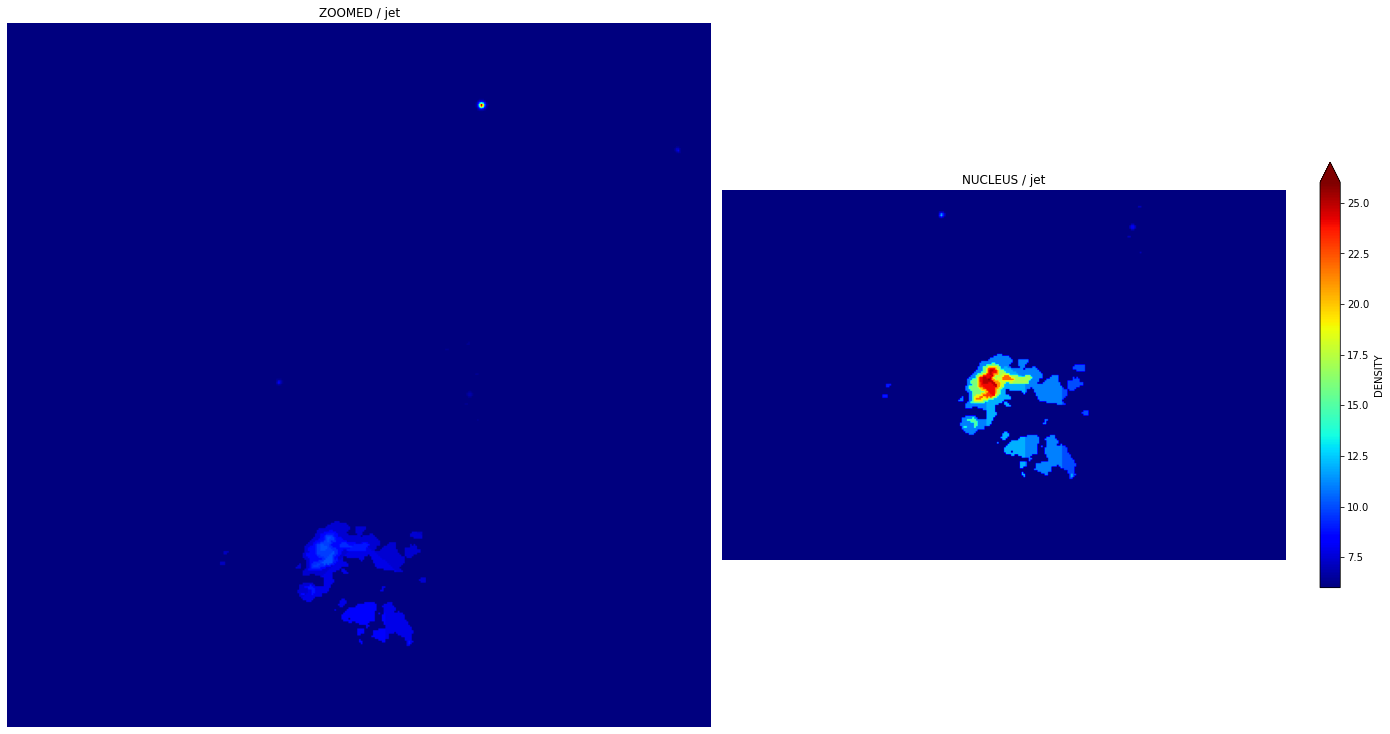

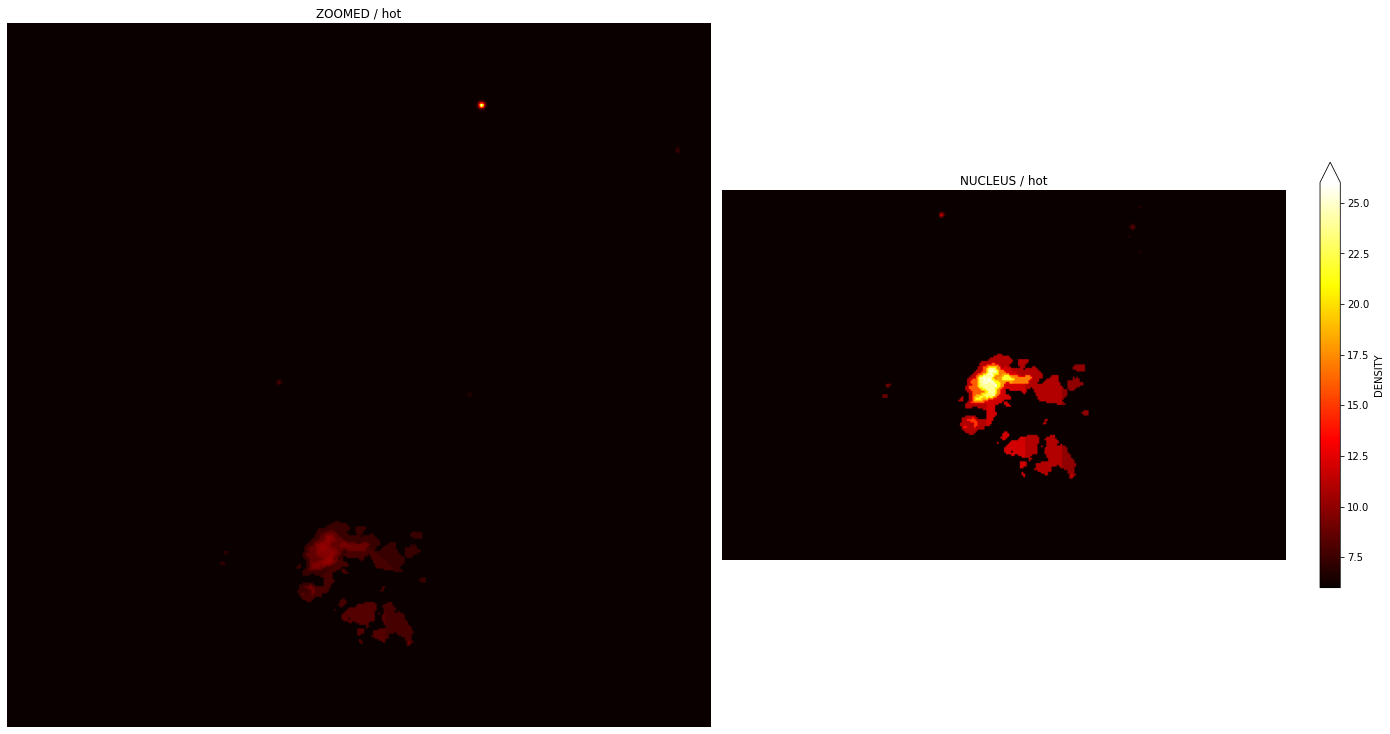

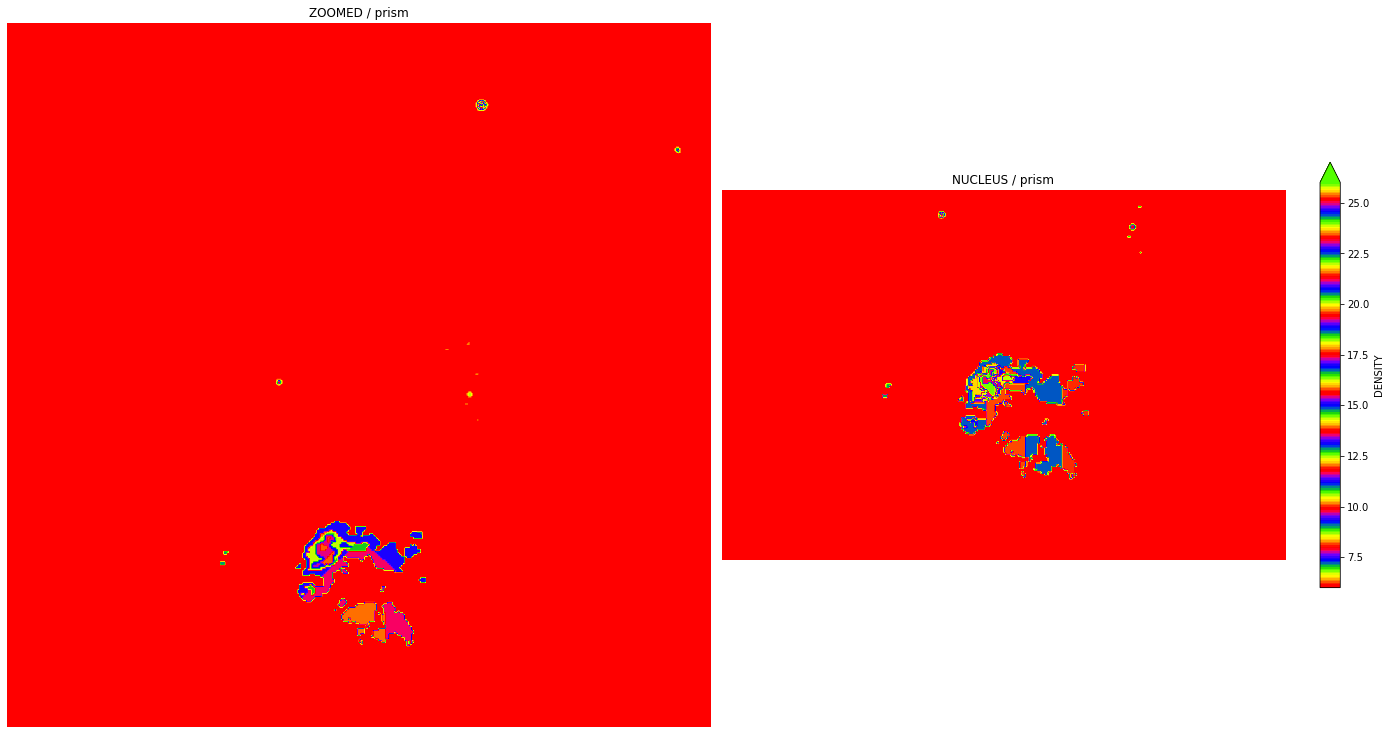

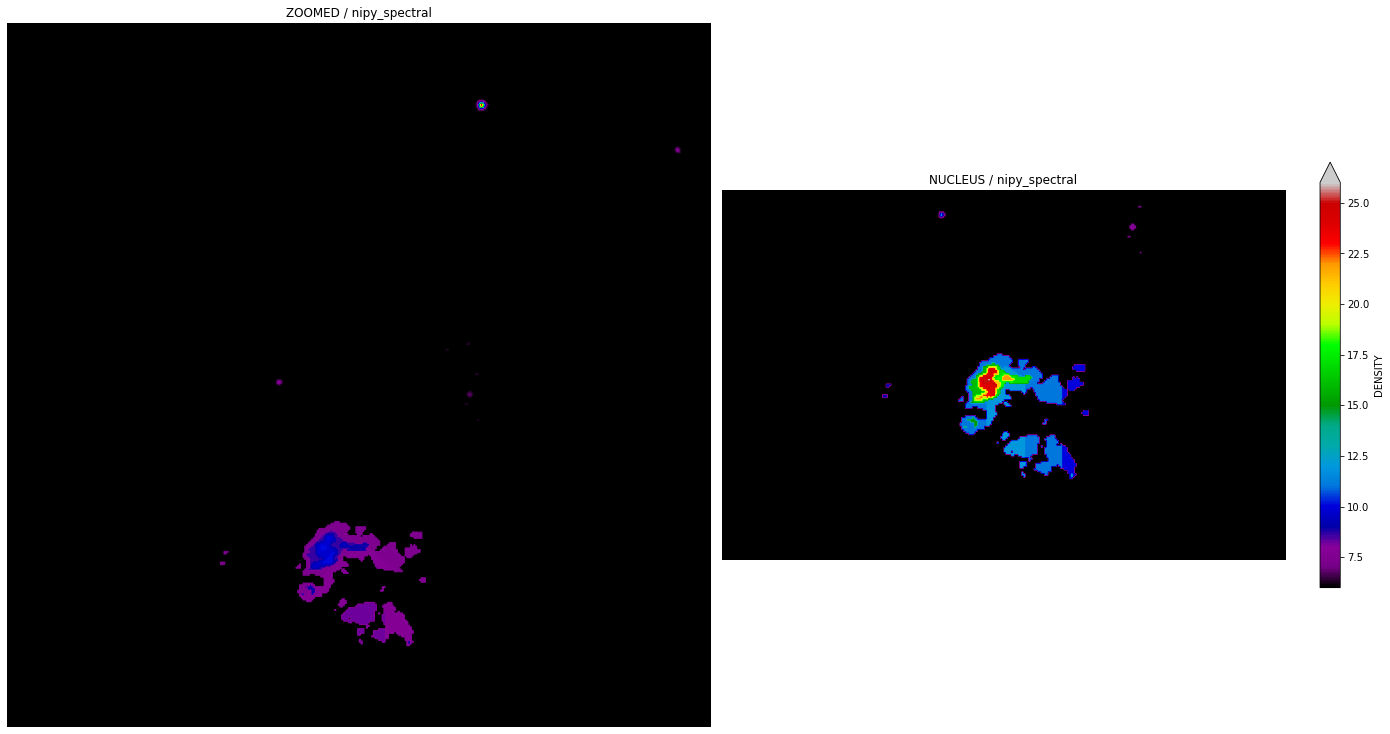

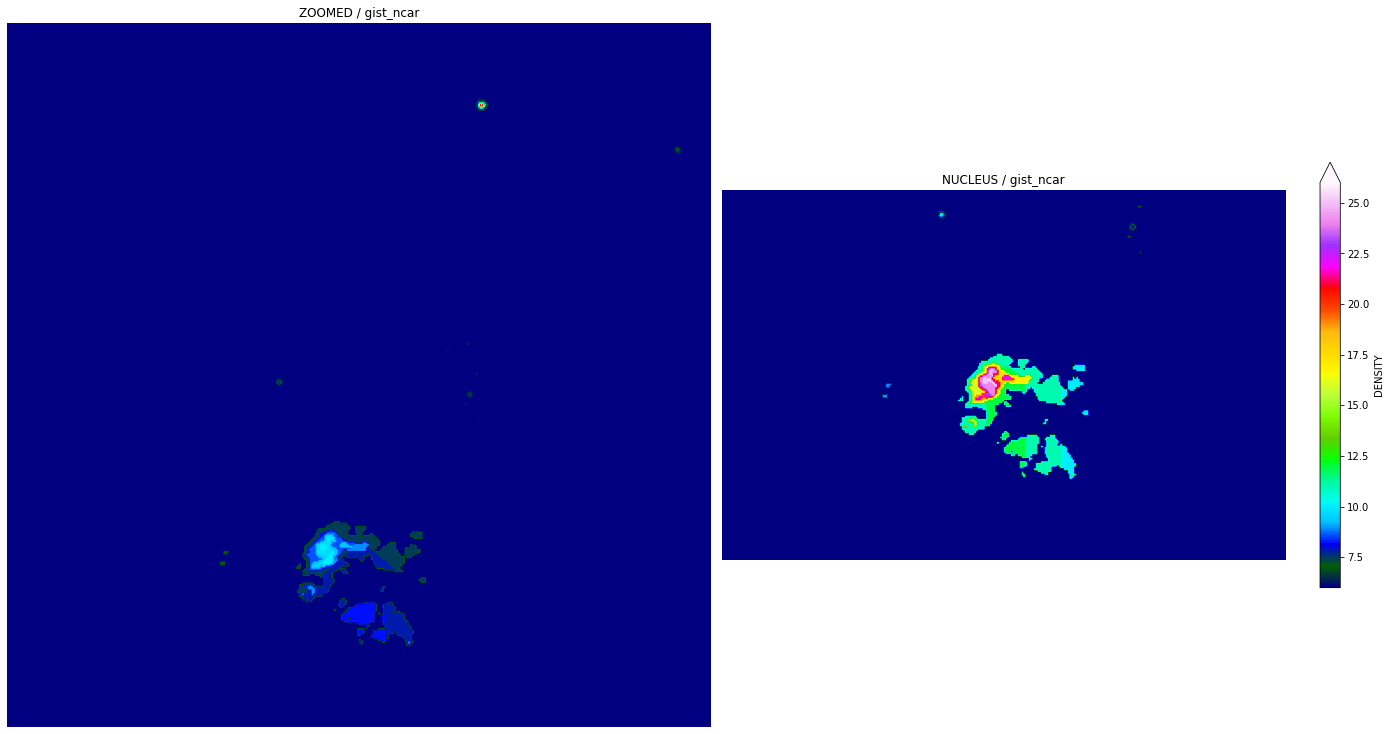

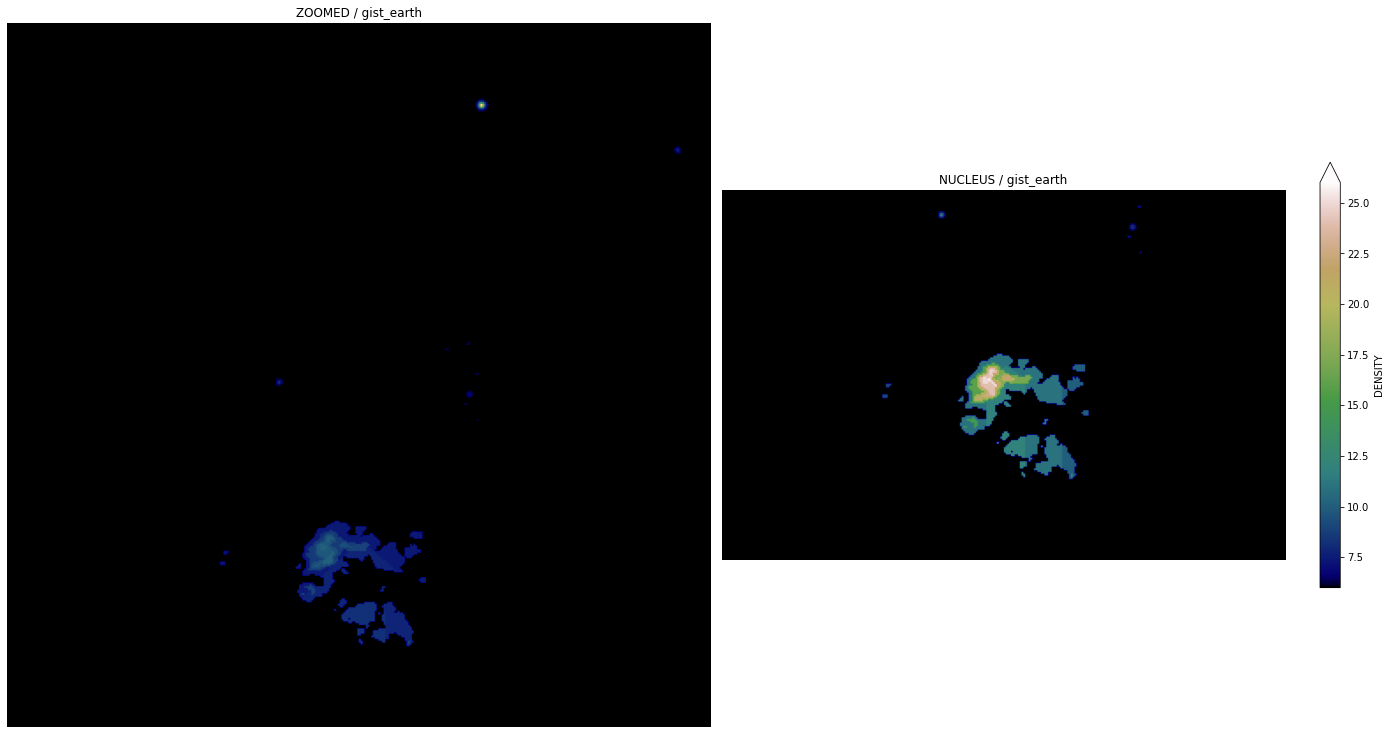

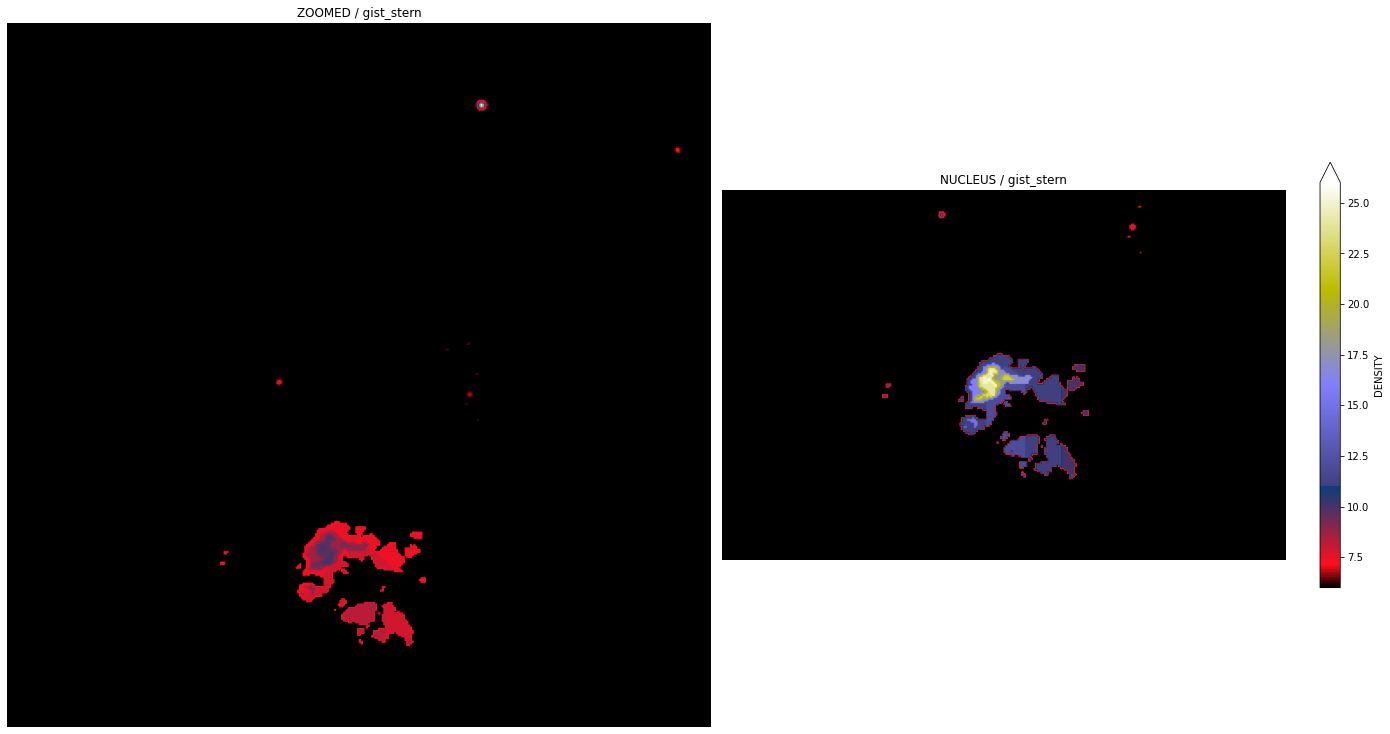

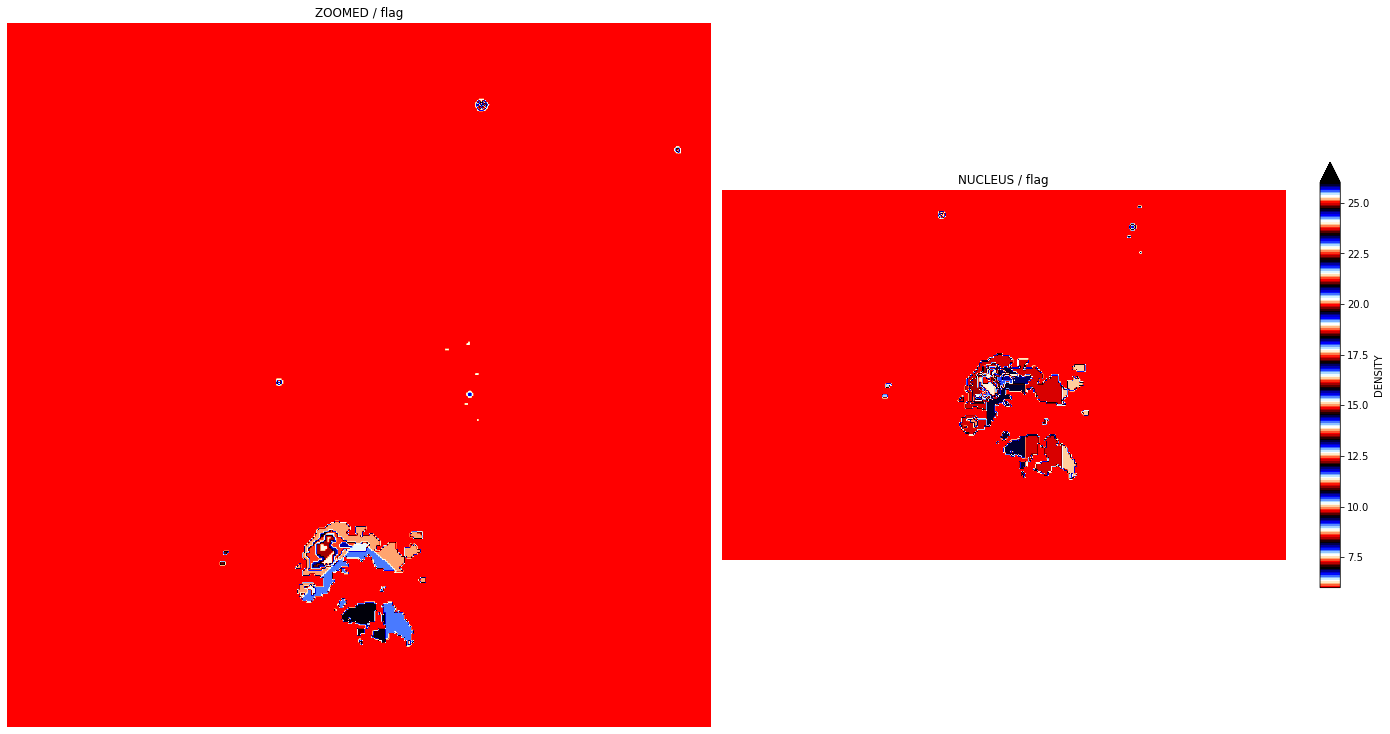

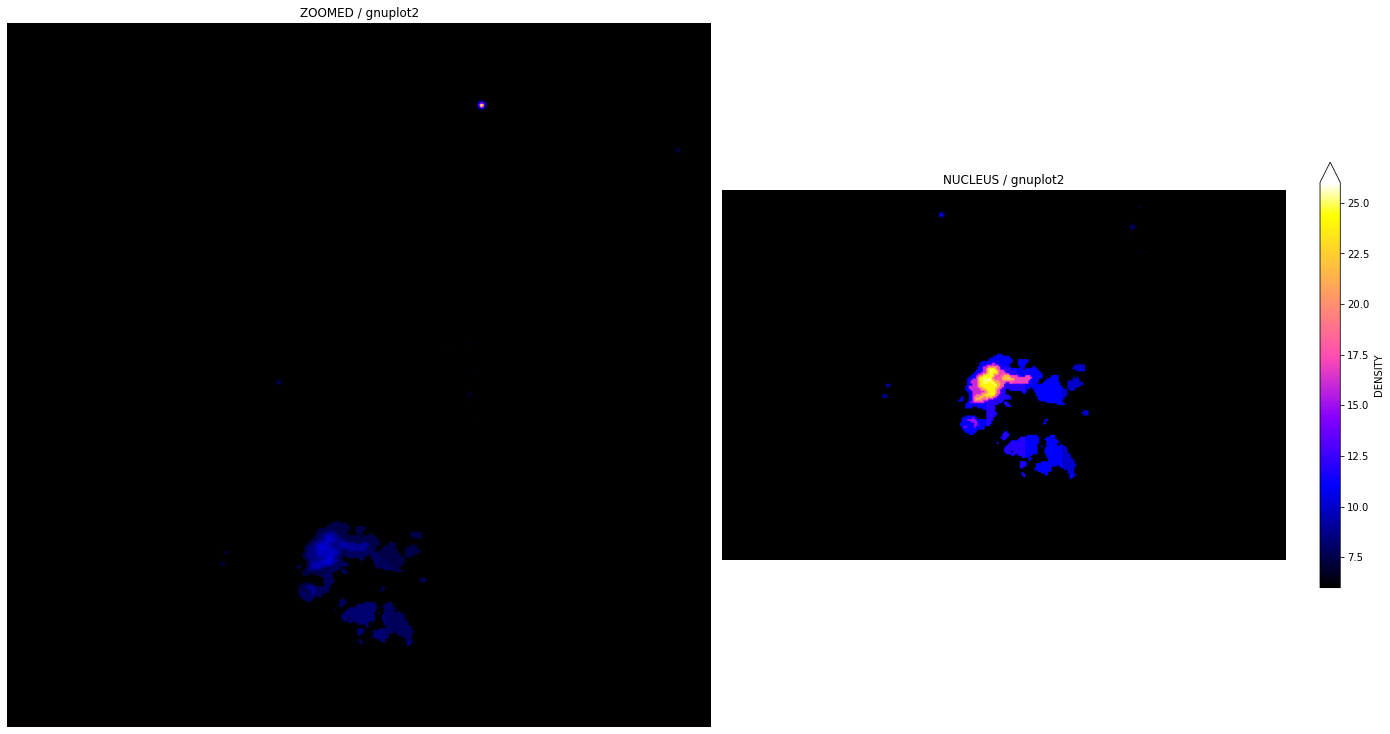

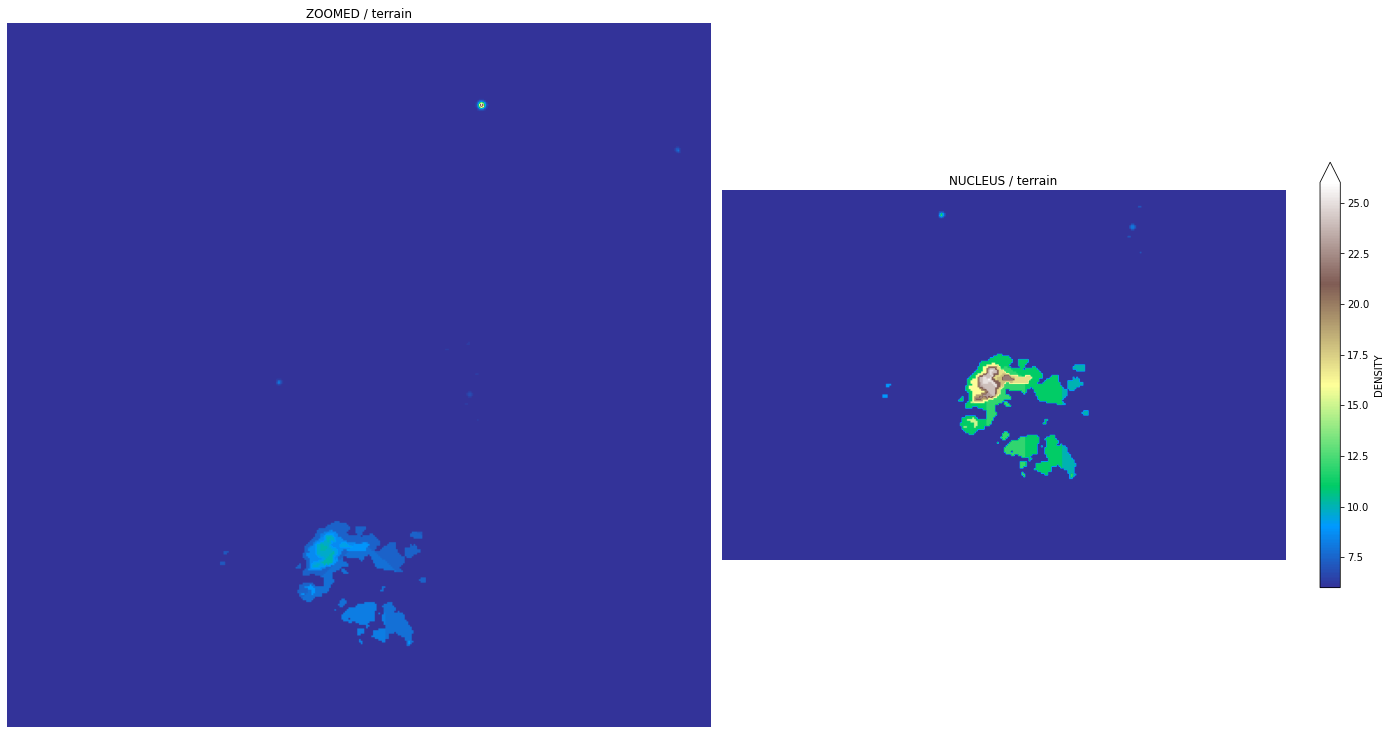

In [36]:
plot_filtrd_imgs(CLAHE_ZOOMED_X2,CLAHE_NUCLEUS_CLAHE,SPECTRAL_LIST)

## Spectroscopy
Astronomical images carry a lot of scientific information hidden within the beautiful colors, but even that’s only part of the story. A great deal of knowledge comes from analyzing the light as broken down into its spectrum. The specific colors and relative amounts of each color reveal information about temperature, what atoms are present, and the speed of the astronomical object being observed, which reveals the distances to far-off galaxies. For those reasons, spectroscopy is one of the essential tools of astronomy.

#### Plotting Spectrograms
A spectrogram is a visual representation of the spectrum of frequencies of a signal as it varies with time. When applied to an audio signal, spectrograms are sometimes called sonographs, voiceprints, or voicegrams. When the data are represented in a 3D plot they may be called waterfall displays.

#### To plot a spectrogram,
1. Take the multi-dimensional image array and apply ```data = numpy.flatten(image)``` to obtain an one dimensional array
2. use ```spectrum, frequencies, time, img = matplotlib.pyplot.specgram(data, sampling frequency)``` to plot the spectrogram. The method also returns spectrum, frequencies, time and the plotted image itself.

In [37]:
#flattening the image
data = ZOOMED_X3_SCALE_HST.flatten()

In [38]:
data

array([0.14134736, 0.22257417, 0.3537239 , ..., 0.11241787, 0.11014394,
       0.10772523], dtype=float32)

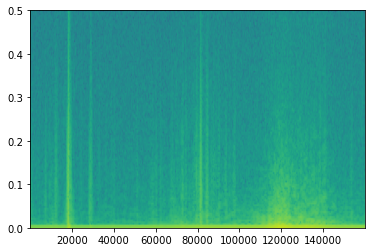

In [39]:
#plotting the spectrogram
powerSpectrum_1, freqenciesFound_1, time_1, imageAxis_1=plt.specgram(data,Fs = 1)

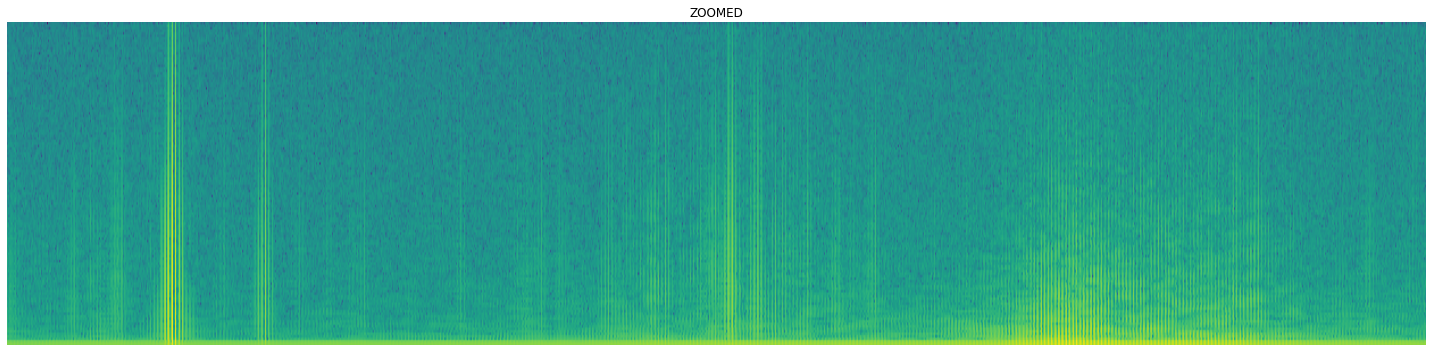

In [40]:
figure = plt.figure(figsize=(20,5))
powerSpectrum_1, freqenciesFound_1, time_1, imageAxis_1 = plt.specgram(ZOOMED_X3_SCALE_HST.flatten(),Fs = 1)
plt.axis("off")
plt.title("ZOOMED")
plt.tight_layout()
plt.show()

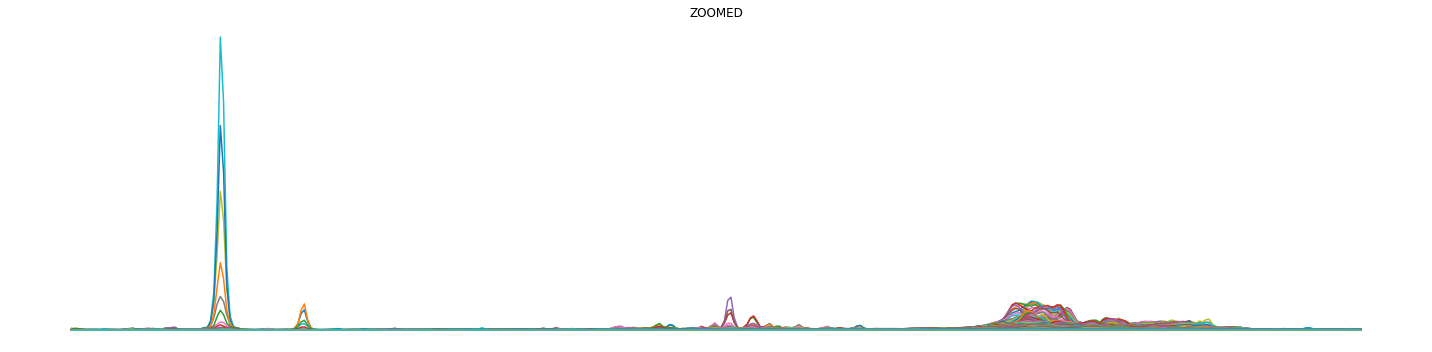

In [41]:
figure = plt.figure(figsize=(20,5))
plt.axis("off")
plt.title("ZOOMED")
plt.tight_layout()
plt.plot(ZOOMED_X3_SCALE_HST)
plt.show()

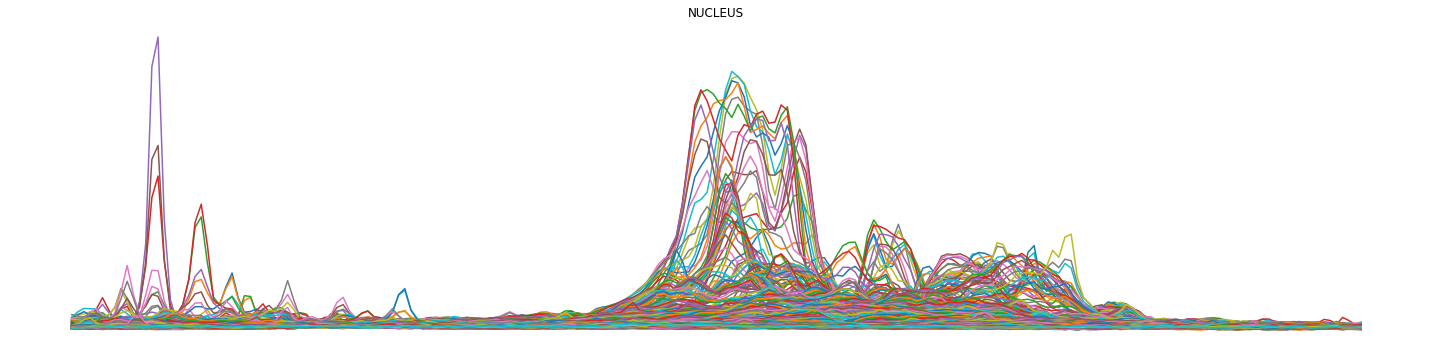

In [42]:
figure = plt.figure(figsize=(20,5))
plt.axis("off")
plt.title("NUCLEUS")
plt.tight_layout()
plt.plot(NUCLEUS_SCALE_HST)
plt.show()

In [46]:
figure = plt.figure(figsize=(20,5))

librosa.display.Waveplot(ZOOMED_X3_SCALE_HST.astype(np.float32),sr=3200)
plt.title("ZOOMED")
plt.tight_layout()
plt.show()

AttributeError: module 'librosa.display' has no attribute 'Waveplot'

<Figure size 1440x360 with 0 Axes>

### Librosa
librosa is a python package for music and audio analysis. It provides the building blocks necessary to create music information retrieval systems. 

Here we use Librosa over matplotlib.pyplot, as all of librosa’s plotting functions rely on matplotlib, but can help generate beautiful visualizations of spectro-temporal data.

#### To plot a spectrogram using Librosa,
1. Compute the short-time Fourier transform,
    ```
    D = librosa.stft(y)
    ```
2. Map the magnitudes to a decibel scale,
    ```
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max) 
    ```
3. Then display the spectrogram, 
    ```
    librosa.display.specshow(S_db)
    ```
4. Use regular Matplotlib.pyplot features to clean up the plot

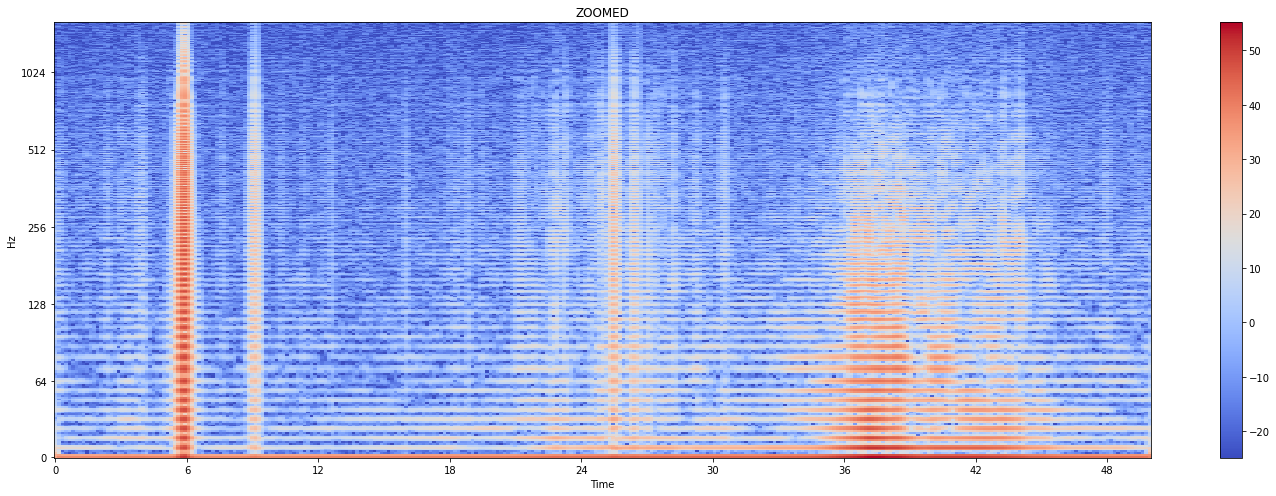

In [47]:
figure = plt.figure(figsize=(20,7))
ZOOMED_X = librosa.stft(ZOOMED_X3_SCALE_HST.flatten().astype(np.float32))
ZOOMED_XDB = librosa.amplitude_to_db(abs(ZOOMED_X))
librosa.display.specshow(ZOOMED_XDB, sr=3200, x_axis='time', y_axis='log')
plt.colorbar()
plt.title("ZOOMED")
plt.tight_layout()
plt.show()

All though astronomical data includes various spectral information that is beyond what human eyes can comprehend, it helps to see it in RGB sometmes. 

#### To visualize the images in RGB,
1. Apply Gaussian filter to the image as Gaussian filters will have the best combination of suppression of high frequencies while also minimizing spatial spread. 
```
gaussian_img = scipy.ndimage.gaussian_filter(image, sigma)
```
2. Lupton et al. (2004) describe an “optimal” algorithm for producing red-green-blue composite images from three separate high-dynamic range arrays. This is found in the Astropy package as 
```
image = make_lupton_rgb(image_r, image_g, image_b, stretch)
```

In [49]:
GAUSS_ZOOMED_X2 = gaussian_filter(ZOOMED_X3_SCALE_HST,sigma=7)
GAUSS_NUCLEUS = gaussian_filter(NUCLEUS_SCALE_HST,sigma=7)

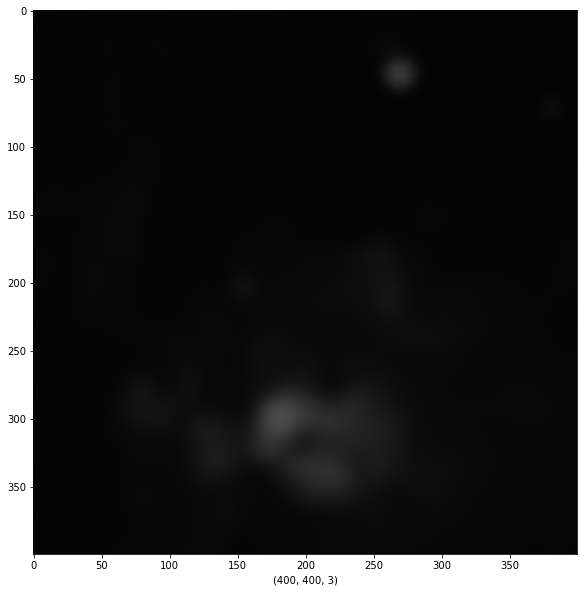

In [50]:
ZOOM_3D = astropy.visualization.make_lupton_rgb(image_r=GAUSS_ZOOMED_X2.astype('float32'),
                                      image_g=GAUSS_ZOOMED_X2.astype('float32'),
                                      image_b=GAUSS_ZOOMED_X2.astype('float32'))
figure =plt.figure(figsize=(15,10))
plt.tight_layout()
plt.imshow(ZOOM_3D)
plt.xlabel(ZOOM_3D.shape)
plt.show()

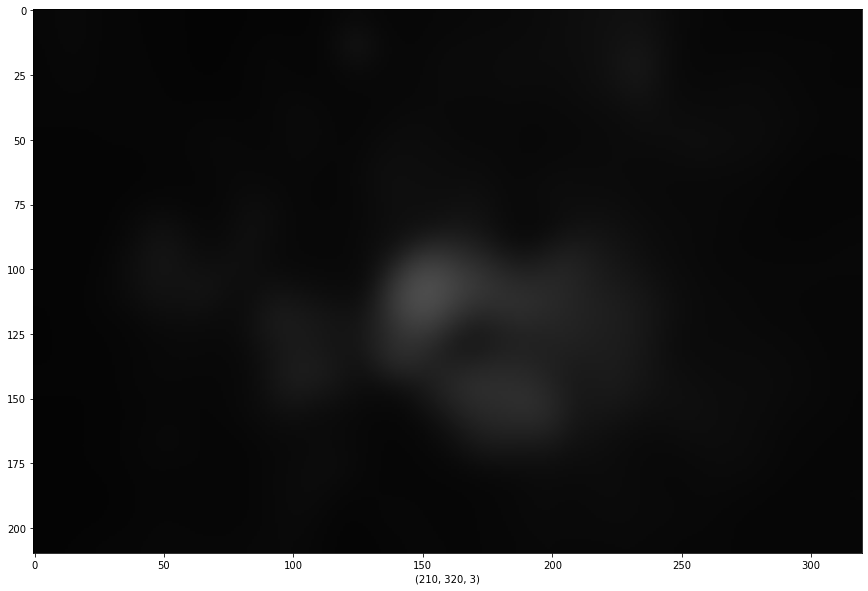

In [51]:
NUCLEUS_3D = astropy.visualization.make_lupton_rgb(image_r=GAUSS_NUCLEUS.astype('float32'),
                                      image_g=GAUSS_NUCLEUS.astype('float32'),
                                      image_b=GAUSS_NUCLEUS.astype('float32'))
figure = plt.figure(figsize=(15,10))
plt.tight_layout()
plt.imshow(NUCLEUS_3D)
plt.xlabel(NUCLEUS_3D.shape)
plt.show()

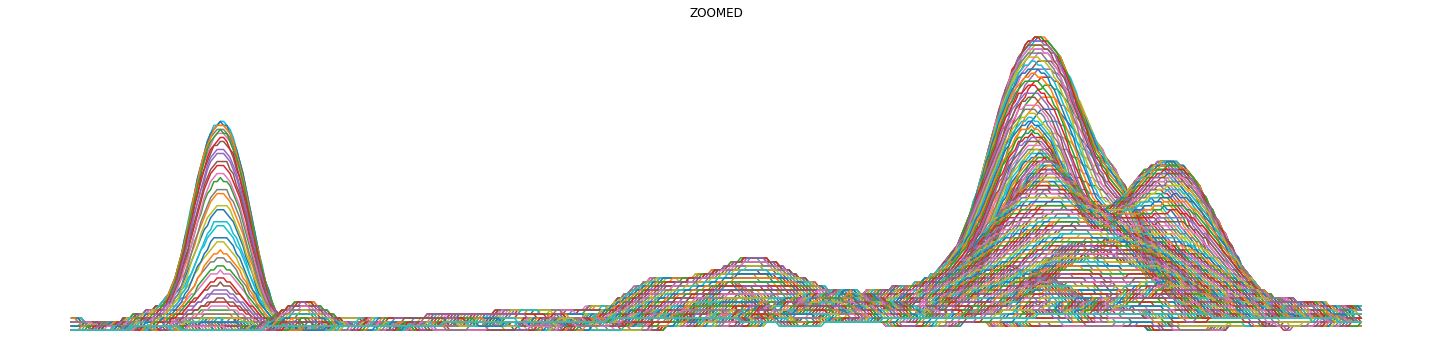

In [52]:
#Slice different color channels
figure = plt.figure(figsize=(20,5))
plt.axis("off")
plt.title("ZOOMED")
plt.tight_layout()
plt.plot(ZOOM_3D[:,:,0])
plt.show()

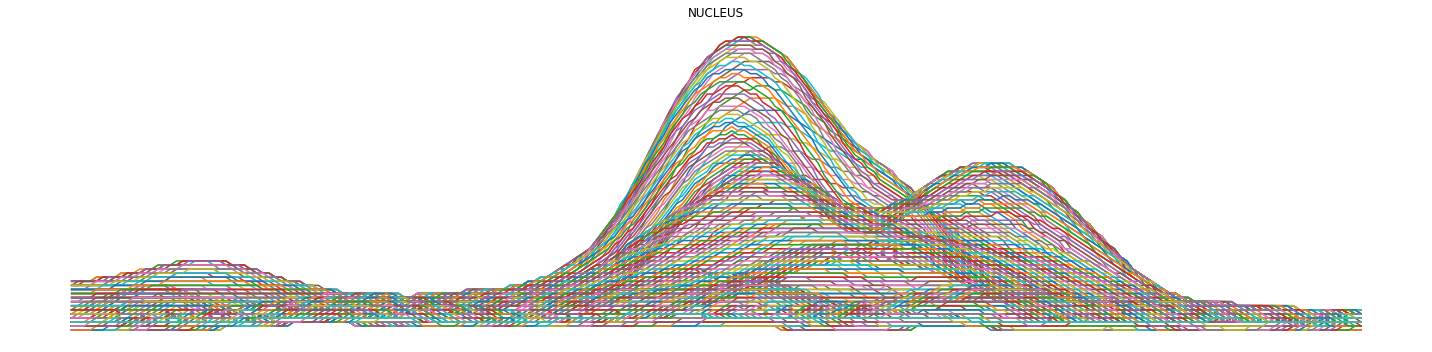

In [53]:
figure = plt.figure(figsize=(20,5))
plt.axis("off")
plt.title("NUCLEUS")
plt.tight_layout()
plt.plot(NUCLEUS_3D[:,:,0])
plt.show()

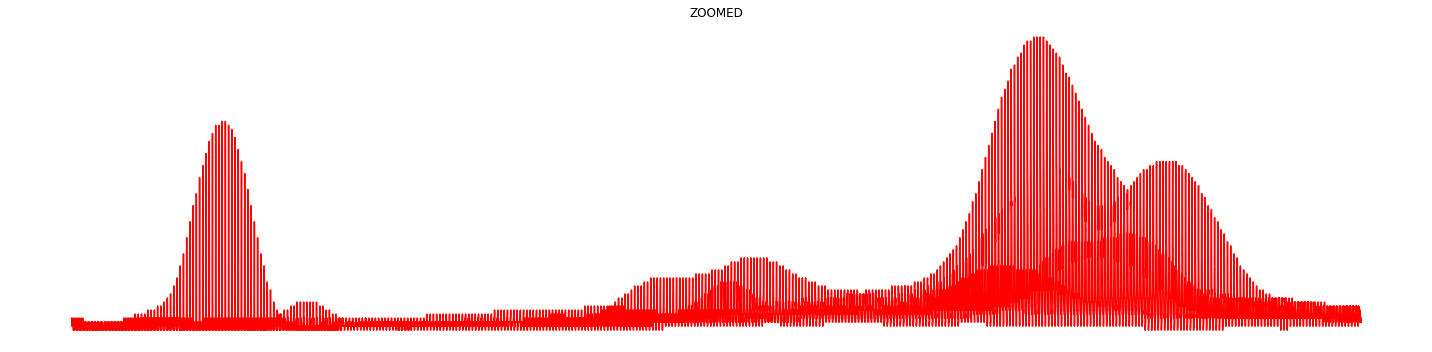

In [54]:
figure = plt.figure(figsize=(20,5))
plt.axis("off")
plt.title("ZOOMED")
plt.tight_layout()
plt.plot(ZOOM_3D.flatten(),color="red")
plt.show()

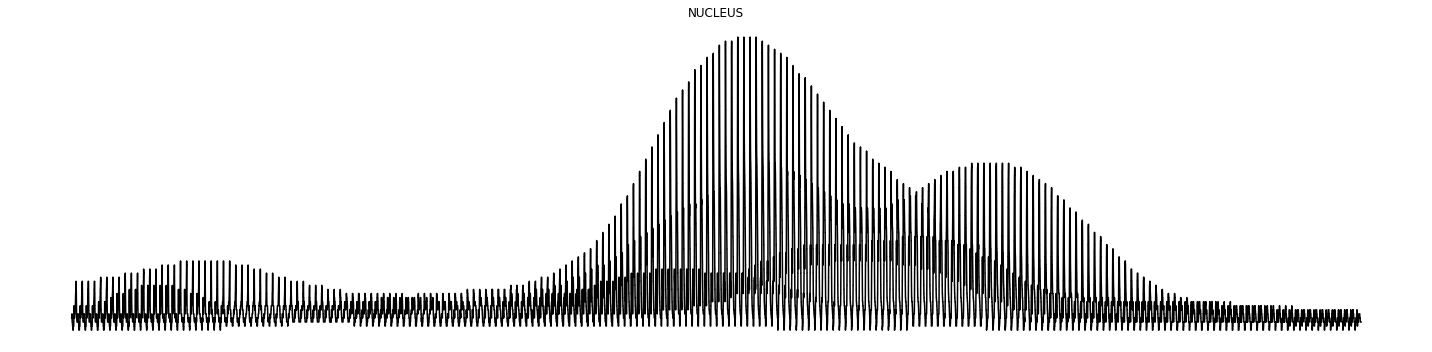

In [55]:
figure = plt.figure(figsize=(20,5))
plt.axis("off")
plt.title("NUCLEUS")
plt.tight_layout()
plt.plot(NUCLEUS_3D.flatten(),color="black")
plt.show()

## Conclusion
A quick wrap up of this notebook,

* Histogram Equalization and the CLAHE technique to improve contrast in images by redistributing luminance.
* Importance of Spectroscopy and how to plot Spectrograms for basic visualization using Matplotlib.pyplot and Advanced visualization using Librosa.
* Visualization of astronomical data in RGB.

## Thanks for reading so far! Feel free to fork this notebook and add your own inputs and experiment! Happy EDA!